<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Agent" data-toc-modified-id="Agent-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Agent</a></span><ul class="toc-item"><li><span><a href="#Random-Agent" data-toc-modified-id="Random-Agent-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Random Agent</a></span></li><li><span><a href="#Q-Learning-Agent" data-toc-modified-id="Q-Learning-Agent-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Q-Learning Agent</a></span></li></ul></li><li><span><a href="#Trainer" data-toc-modified-id="Trainer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trainer</a></span></li><li><span><a href="#Stochasticity" data-toc-modified-id="Stochasticity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stochasticity</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
import time

In [2]:
path = 'static_images2/'

## Environment 

In [3]:
class GridEnvironment:
    def __init__(self, path, stochastic = False):
        self.path = path
        self.size = 5
        self.observation_space = np.zeros((self.size,self.size))
        self.action_space = 4
        self.max_timesteps = 9
        self.stochastic = stochastic
        
        if self.stochastic:
            self.max_timesteps *= 2
        
        agent = cv2.imread(path + 'agent.jpeg')
        goal1 = cv2.imread(path + 'food.jpeg')
        goal2 = cv2.imread(path + 'food2.jpeg')
        villain = cv2.imread(path + 'villain.jpeg')
        
        self.static_files = {'agent': agent,
                             'goal1': goal1,
                             'goal2': goal2,
                             'villain': villain}
    
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.array([0,2])
        self.goals = {'goal1': {'pos':np.array([4,0]), 'captured':False},
                      'goal2': {'pos':np.array([4,4]), 'captured':False}}
        self.villain = [{'pos': np.array([1,4]), 'captured': False}, 
                        {'pos': np.array([2,2]), 'captured': False},
                        {'pos': np.array([3,1]),'captured': False}]
        
        return self.agent_pos.copy()
    
    def step(self, action):
        
        self.timestep += 1
        direction = 1
        if self.stochastic:
            direction = np.random.choice([1,-1], p=[0.8, 0.2])
        
        if action == 0:
            #ACTION UP
            self.agent_pos[0] -= direction
        elif action == 1:
            #ACTION Down
            self.agent_pos[0] += direction
        elif action == 2:
            #ACTION right
            self.agent_pos[1] += direction
        elif action == 3:
            #ACTION left
            self.agent_pos[1] -= direction
            
        self.agent_pos = self.agent_pos.clip(0, self.size-1)
        if self.agent_pos[0] == self.size or self.agent_pos[1] == self.size:
            import pdb; pdb.set_trace()
#         reward = 0

        done = False
        reward = 0

        for villain in self.villain:
            if (self.agent_pos == villain['pos']).all():
                reward -= 10
                done = True
                villain['captured'] = True
                break
                
        if not done:
            if (self.agent_pos == self.goals['goal2']['pos']).all():
                reward += 20
                self.goals['goal2']['captured'] = True
                done = True
            elif (self.agent_pos == self.goals['goal1']['pos']).all() and not self.goals['goal1']['captured']:
                reward += 5
                done = True
                self.goals['goal1']['captured'] = True
            else:
                reward -= 1
                
            
            
        done = self.timestep >= self.max_timesteps or done
        
        return self.agent_pos, reward, done
    
    def render(self):
        env = cv2.imread(self.path + 'grid_world.jpeg')
        height = width = 120
        
        draw_agent = True
        if not self.goals['goal1']['captured']:
            goal1 = self.goals['goal1']['pos']*height
            env[goal1[0]:goal1[0] + height, goal1[1]:goal1[1] + height, :] = self.static_files['goal1']
        
        if not self.goals['goal2']['captured']:
            goal2 = self.goals['goal2']['pos']*height
            env[goal2[0]:goal2[0] + height, goal2[1]:goal2[1] + height, :] = self.static_files['goal2']
        
        for villain in self.villain:
            if villain['captured']:
                draw_agent = False
            villain = villain['pos']*height
            env[villain[0]:villain[0] + height, villain[1]:villain[1] + height, :] = self.static_files['villain']
            
        if draw_agent:
            agent = self.agent_pos*height
            env[agent[0]:agent[0] + height, agent[1]:agent[1] + height, :] = 0
            env[agent[0]:agent[0] + height, agent[1]:agent[1] + height, :] = self.static_files['agent']
        else:
            print ("YOU LOST")
        plt.figure(figsize=(8,8), dpi=90)
        plt.imshow(env)
        
    def set_stochastic(self, stochastic):
        self.stochastic = stochastic

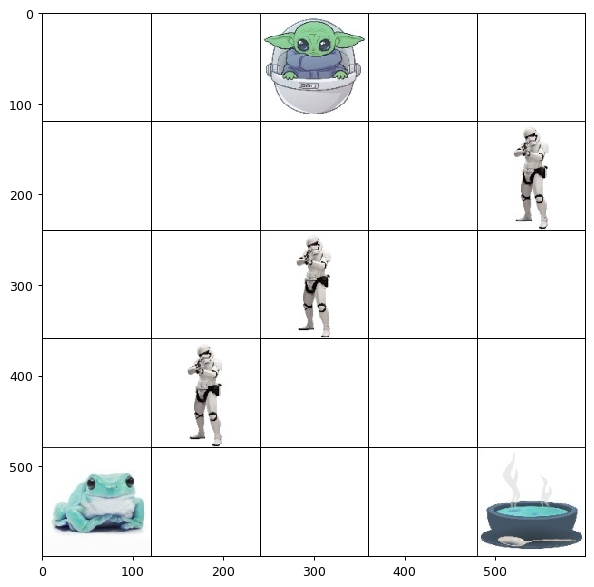

In [4]:
env = GridEnvironment(path)
obs = env.reset()
env.render()

## Agent

### Random Agent

In [5]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

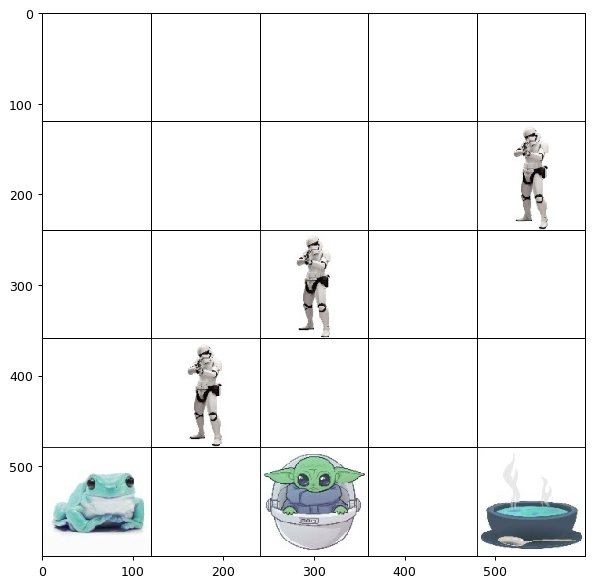

In [6]:
env = GridEnvironment(path)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    clear_output(wait=True)
    time.sleep(0.5)
    action = agent.step(obs, verbose=True)
    obs, reward, done = env.step(action)
    env.render()
    plt.show()

### Q-Learning Agent

In [7]:
class QLearningAgent:
    def __init__(self, env, epsilon=1, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        
        q_table_dim = self.observation_space.shape[0]
        self.q_table = np.zeros((q_table_dim, q_table_dim, self.action_space))
    
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        
    def policy(self, observation):
        if np.random.uniform(0,1) > self.epsilon:
            return np.argmax(self.q_table[tuple(observation)])
        else:
            return np.random.randint(0,4)
    
    def step(self, observation):
        return self.policy(observation)
    
    def update(self, state, action, reward, next_state):
#         print (state, next_state, action, self.q_table[tuple(state)][action], self.q_table[tuple(next_state)])
        self.q_table[tuple(state)][action] = (1 - self.lr) * self.q_table[tuple(state)][action] + self.lr * (reward + self.gamma * np.max(self.q_table[tuple(next_state)]))
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
        
    def set_q_table(self, q_table):
        self.q_table = q_table

## Trainer

In [31]:
def training(path, num_epochs, delta_epsilon, stochastic=False, verbose=False):
    env = GridEnvironment(path, stochastic)
    agent = QLearningAgent(env)
    total_rewards = []
    epsilons = [agent.epsilon]
    all_actions = []
    epochs = num_epochs
    
    startTime = time.time()
    for i in range(epochs):
        obs = env.reset()
        reward_current_episode = 0
        done = False
        actions = []

        while not done:
            try:
                action = agent.step(obs)
                new_state, reward, done = env.step(action)
                agent.update(obs, action, reward, new_state)
                obs = new_state.copy()
                reward_current_episode += reward
                actions.append(action)
                if verbose:
                    if i == epochs - 1:
        #                 clear_output(wait=True)
                        env.render()
                    else:
                        clear_output()
            except Exception as e:
                print (e)

        all_actions.append(actions)
        new_epsilon = epsilons[-1]*delta_epsilon
        epsilons.append(new_epsilon)
        agent.set_epsilon(new_epsilon)
        total_rewards.append(reward_current_episode)
        
        
    return {'list_epsilons': epsilons,
           'total_rewards': total_rewards,
           'time_taken': time.time() - startTime,
           'agent': agent,
           'environment': env}

In [38]:
def plot_rewards(data, flag):
    window = 10
    plt.figure(figsize = (12,8))
    plt.xlabel('Episode', fontsize = 14)
    plt.ylabel('Total Reward (SMA 10)', fontsize = 14)
    for key, value in data.items():
        df = value[flag]['total_rewards']
        plt.plot([np.mean(df[tr:tr+window]) for tr in range(window, len(df))])
    plt.legend(data.keys(), loc='lower right', fontsize = 14)
    plt.title('Rewards vs Episode for various epsilon decay rates (' + flag + ')', fontsize = 16)
    plt.show()

In [39]:
def plot_decay(data, flag):
    plt.figure(figsize = (12,8))
    plt.xlabel('Episode', fontsize = 14)
    plt.ylabel('$\epsilon$', fontsize = 14)
    for key, value in data.items():
        df = value[flag]['list_epsilons']
        plt.plot(df)
    plt.legend(data.keys(), loc='upper right', fontsize = 14)
#     plt.legend(['Exponential Decay rate -' + str(delta_epsilon)])
    plt.title('Rate of change of $\epsilon$ (' + flag + ')', fontsize = 16)
    plt.show()

In [34]:
infos = {}
for i in [0.95, 0.97, 0.99]:
    infos[i] = {'deterministic': training(path, num_epochs=400, delta_epsilon=i, verbose=False),
               'stochastic':training(path, num_epochs=400, delta_epsilon=i, stochastic=True, verbose = False)}

In [37]:
print ("Time taken (deterministic): ", infos[i]['deterministic']['time_taken'])
print ("Time taken (stochastic): ", infos[i]['stochastic']['time_taken'])

Time taken (deterministic):  0.2176809310913086
Time taken (stochastic):  0.524634838104248


# Observations
1. A complex environment will require you to train the agent for significantly large number of iterations. An example of such an environment can be if two agents block the path - [2,2] and [2,4]
2. **Q-learning** is more widely used than **DP** most probably due to it's simplicity. You don't even need to do policy updation as we can greedily choose it from the Q-values.


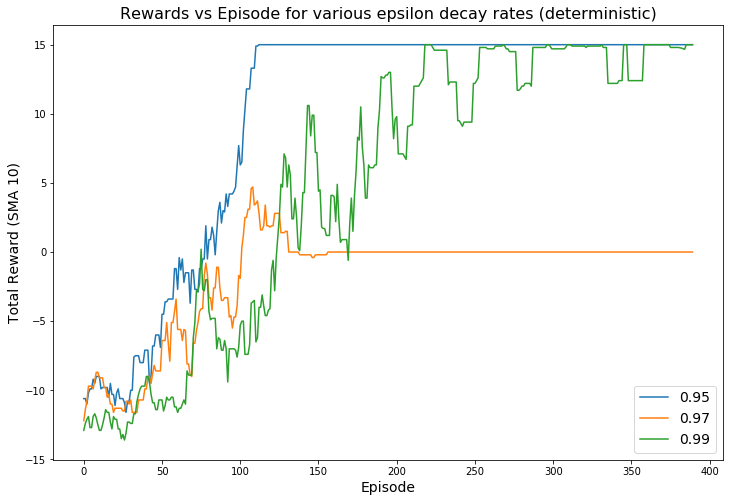

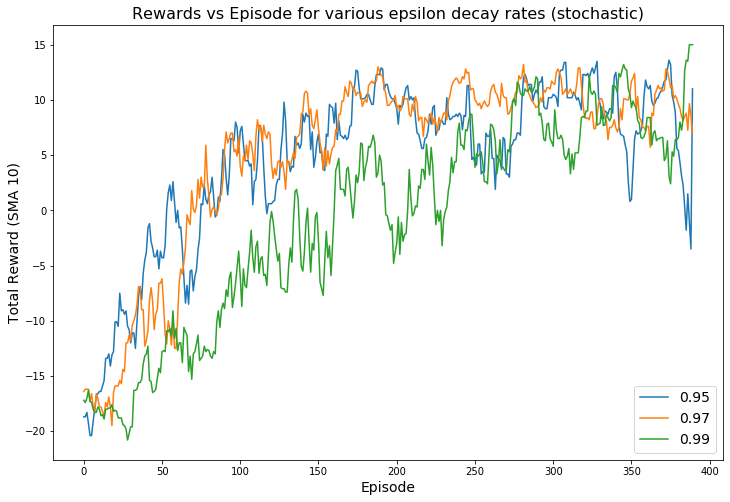

In [40]:
plot_rewards(infos, flag = 'deterministic')
plot_rewards(infos, flag = 'stochastic')

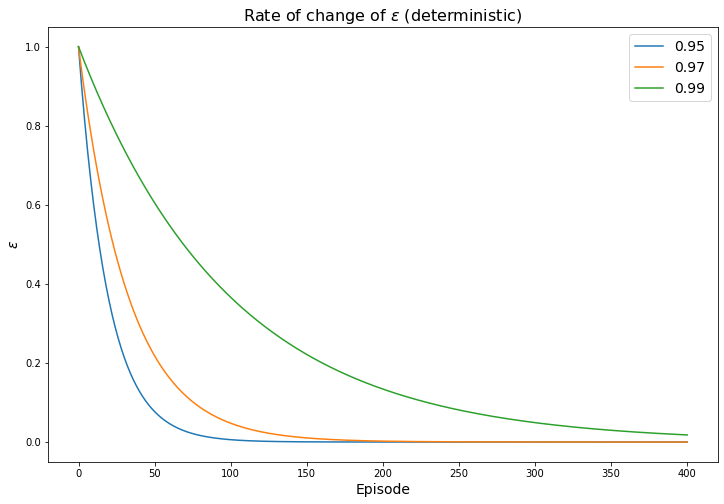

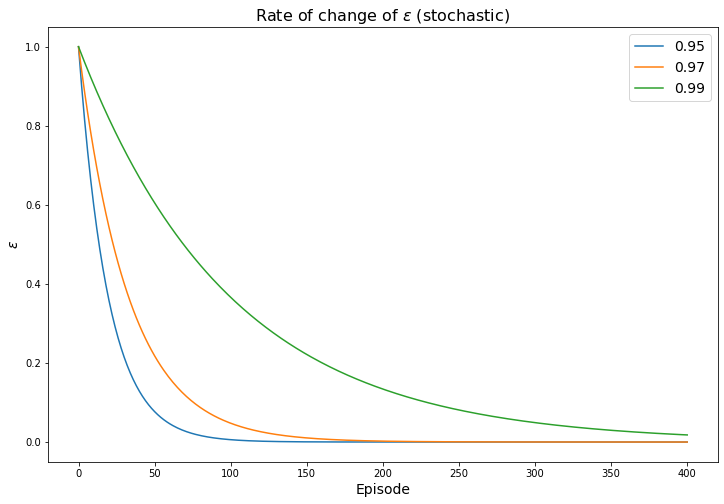

In [43]:
plot_decay(infos, flag = 'deterministic')
plot_decay(infos, flag = 'stochastic')

## Stochasticity

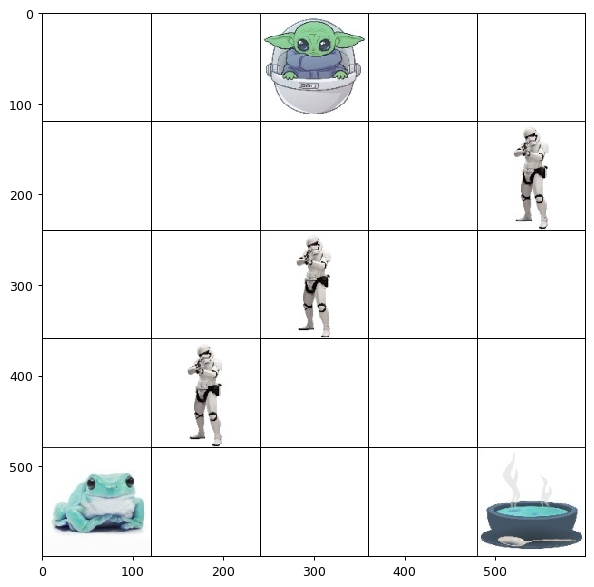

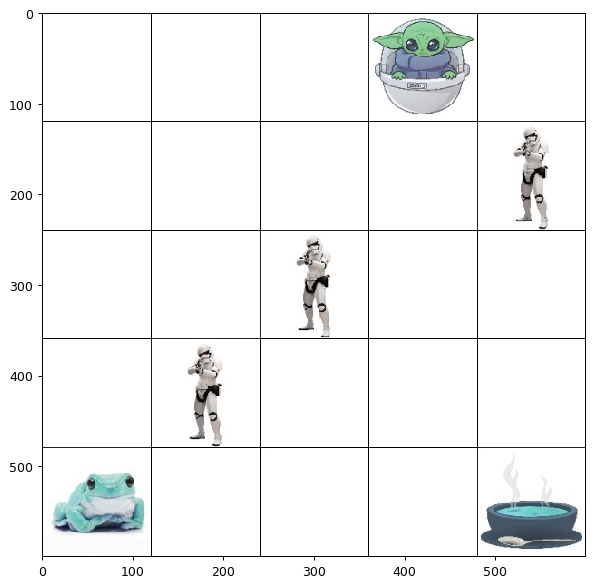

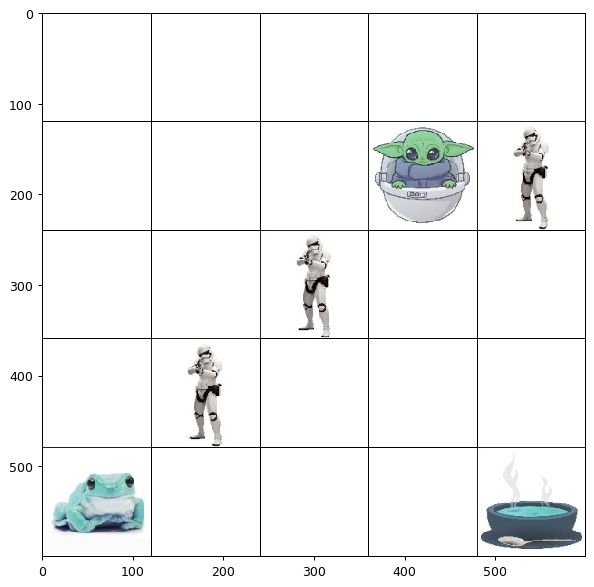

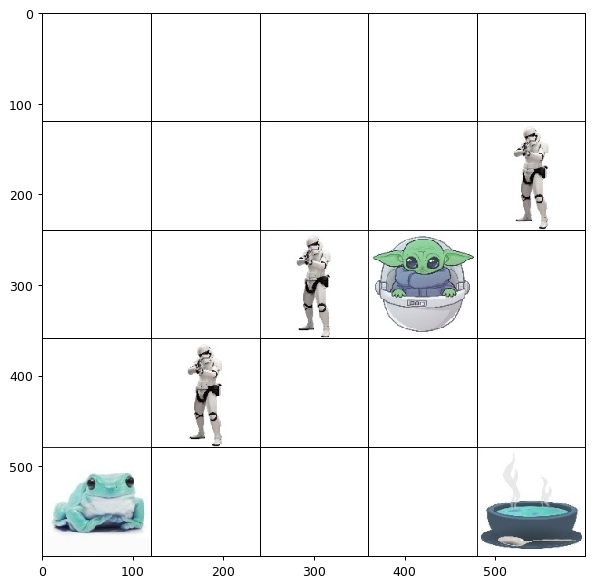

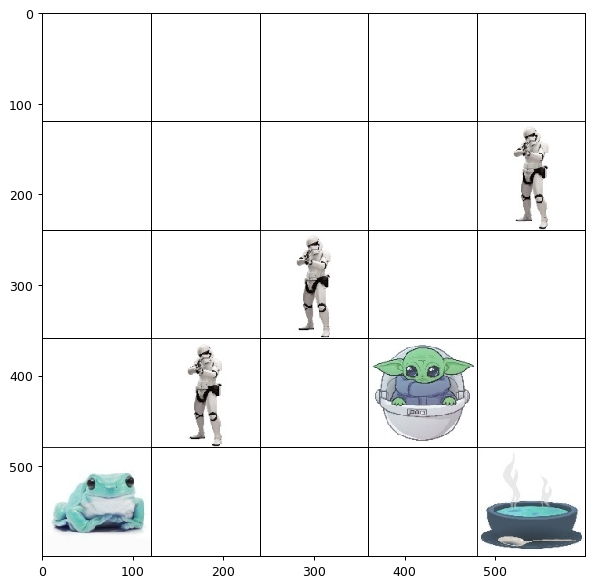

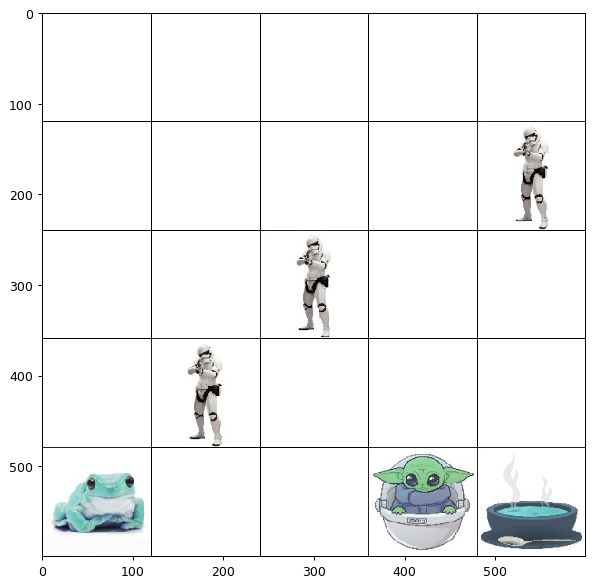

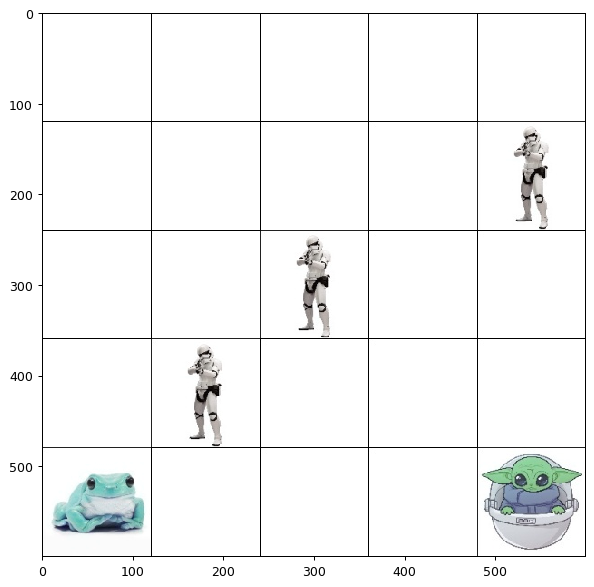

In [45]:
env = infos[0.97]['deterministic']['environment']
agent = infos[0.97]['stochastic']['agent']
env.set_stochastic(False)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()
total_reward = 0
while not done:
#     clear_output(wait=True)
#     time.sleep(0.1)
    action = agent.step(obs)
    obs, reward, done = env.step(action)
    total_reward += reward
    env.render()
    plt.show()

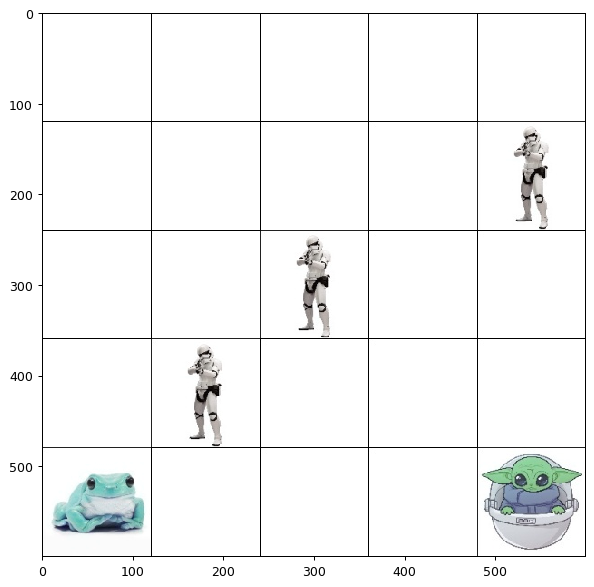

In [23]:
env = info['environment']
agent = info['agent']
env.set_stochastic(True)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()
total_reward = 0
while not done:
    clear_output(wait=True)
    time.sleep(0.1)
    action = agent.step(obs)
    obs, reward, done = env.step(action)
    total_reward += reward
    env.render()
    plt.show()

# Candy Question

Assume that neither of the goals (frog and soup) are terminal states. What do you expect the agent will do after it reaches one of them?